In [14]:
import vit as vit
import importlib
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
importlib.reload(vit)
image_size=512
model = vit.vit_b16(image_size, pretrained=True)

d:\insa\5if\KTH\P4\DL\Project\TransUnet\models\vit-keras\utils.py:84: UserWarning: Resizing position embeddings from 24 to 32
  UserWarning,
d:\insa\5if\KTH\P4\DL\Project\TransUnet\models\vit-keras\utils.py:201: UserWarning: Did not use the following weights: {'head/kernel', 'head/bias', 'cls'}
  f"Did not use the following weights: {unused}", UserWarning)


In [11]:
data = np.load("../../data/train_npz/case0007_slice085.npz")
image = data["image"]
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)

In [12]:
y = model.predict(X)
y.shape

(1, 1024, 768)

In [13]:
patches = y.reshape((1, 1024, 16, 16, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


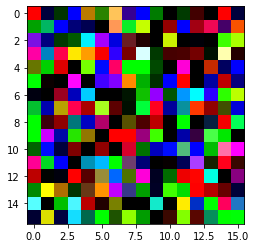

In [19]:
plt.imshow(patches[0, 60, :, :, :])